# **Desarrollo e Implementación de una CNN para la creación de un sistema de detección de intrusiones**

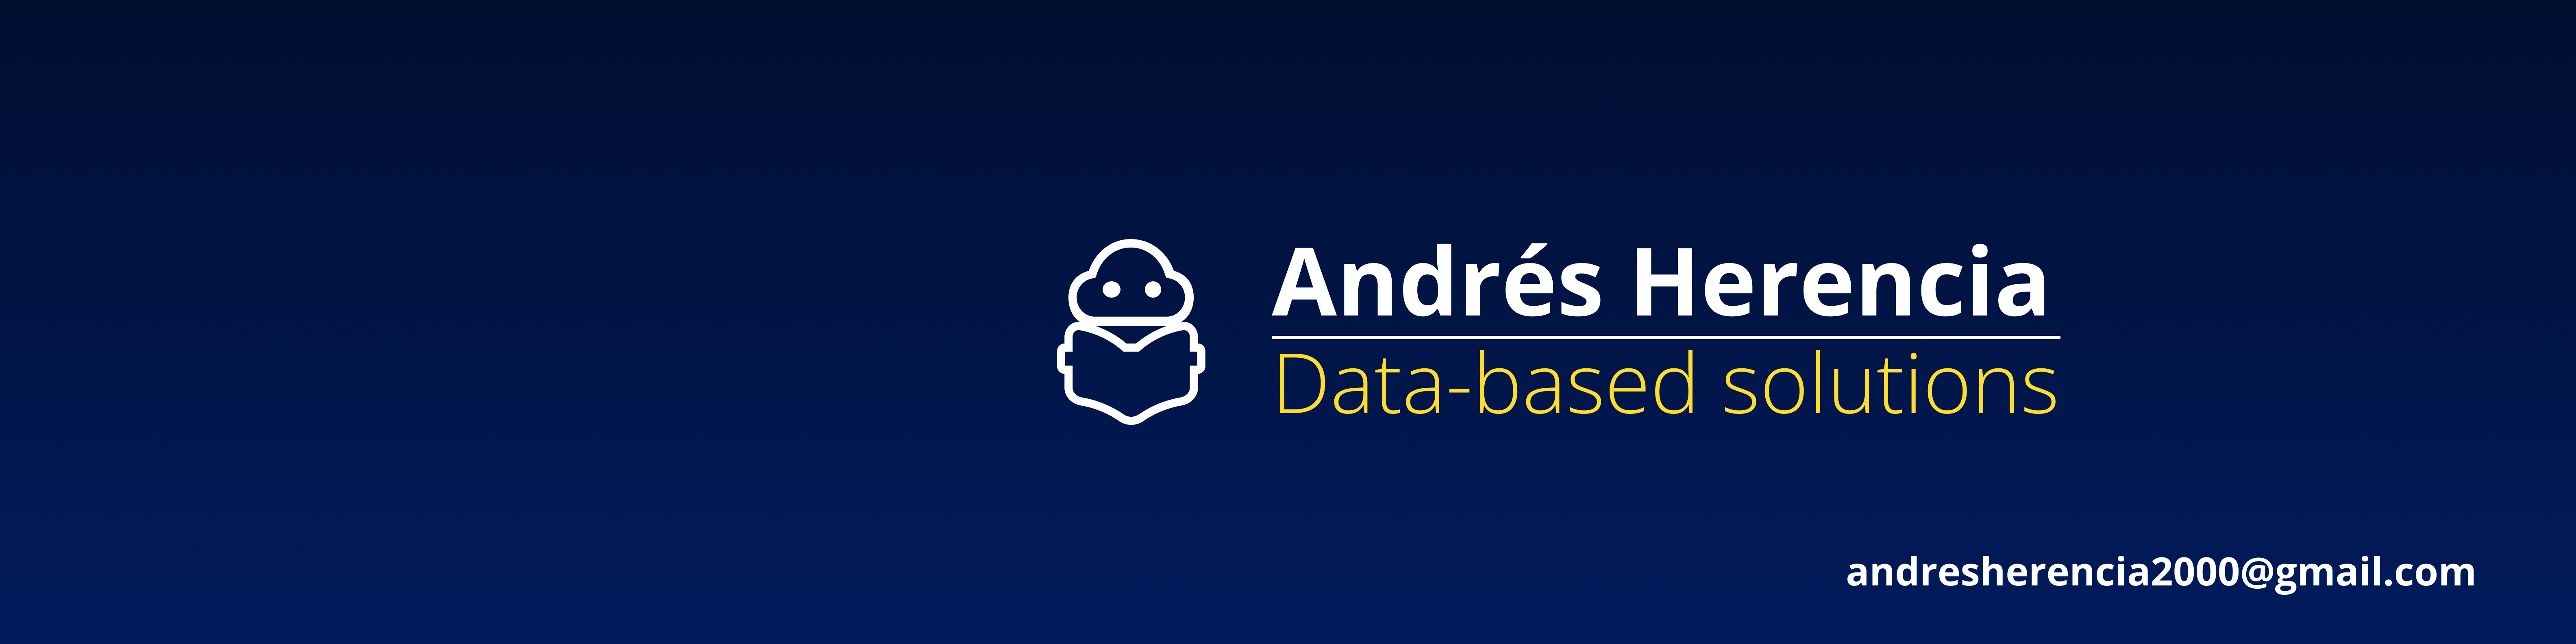

**MUTECI 2023/2024**

*Redes Neuronales y Aprendizaje Estadístico*

Andrés Herencia López-Menchero

## Librerías

In [44]:
!pip install keras-tuner
!pip install keras-wrappers
!pip install --upgrade tensorboard

ERROR: Could not find a version that satisfies the requirement keras-wrappers (from versions: none)
ERROR: No matching distribution found for keras-wrappers


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras_tuner import Hyperband, RandomSearch
from tensorflow import keras
from tensorflow.keras.callbacks import Callback

import datetime

ModuleNotFoundError: No module named 'keras.wrappers'

## Carga de datos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import gdown
import os

url = 'https://drive.google.com/uc?id=1PcO0wgUFk-zEa_udQ2726akzNvPkuBpu'
output = 'iot_network.csv'
if not os.path.exists(output):
    gdown.download(url, output, quiet=False)
else:
    print(f"El archivo {output} ya existe y no será descargado nuevamente.")

Downloading...
From (original): https://drive.google.com/uc?id=1PcO0wgUFk-zEa_udQ2726akzNvPkuBpu
From (redirected): https://drive.google.com/uc?id=1PcO0wgUFk-zEa_udQ2726akzNvPkuBpu&confirm=t&uuid=0297d5f8-d5e8-464a-8724-06b87d00e701
To: /content/iot_network.csv
100%|██████████| 309M/309M [00:06<00:00, 49.3MB/s]


In [6]:
route = '/content/drive/MyDrive/RNAE'
df = pd.read_csv('iot_network.csv')
df

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:53 AM,75,1,1,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,2179,192.168.0.13,554,6,26/05/2019 10:11:06 PM,5310,1,2,...,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS,DoS-Synflooding
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:48 AM,141,0,3,...,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan,Scan Port OS
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,52964,192.168.0.13,9020,6,04/09/2019 03:58:17 AM,151,0,2,...,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai,Mirai-Hostbruteforceg
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,36763,239.255.255.250,1900,17,10/09/2019 01:41:18 AM,153,2,1,...,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai,Mirai-Hostbruteforceg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625778,192.168.0.24-210.89.164.90-56112-8043-17,192.168.0.24,56112,210.89.164.90,8043,17,25/07/2019 03:25:00 AM,277,1,1,...,0.0,0.0,0.0,277.0,0.000000,277.0,277.0,Anomaly,Mirai,Mirai-UDP Flooding
625779,192.168.0.13-222.131.171.244-554-4570-6,222.131.171.244,4570,192.168.0.13,554,6,26/05/2019 10:06:51 PM,1658,0,2,...,0.0,0.0,0.0,1658.0,0.000000,1658.0,1658.0,Anomaly,DoS,DoS-Synflooding
625780,192.168.0.13-192.168.0.16-9020-52739-6,192.168.0.16,52739,192.168.0.13,9020,6,11/07/2019 01:29:09 AM,77,1,1,...,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Anomaly,Scan,Scan Port OS
625781,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 05:00:29 AM,240,2,1,...,0.0,0.0,0.0,120.0,7.071068,125.0,115.0,Normal,Normal,Normal


In [7]:
df['Cat'].unique()

array(['Mirai', 'DoS', 'Scan', 'Normal', 'MITM ARP Spoofing'],
      dtype=object)

In [8]:
df['Sub_Cat'].unique()

array(['Mirai-Ackflooding', 'DoS-Synflooding', 'Scan Port OS',
       'Mirai-Hostbruteforceg', 'Mirai-UDP Flooding',
       'Mirai-HTTP Flooding', 'Normal', 'Scan Hostport',
       'MITM ARP Spoofing'], dtype=object)

In [9]:
# for observing in notepad purpouses
df_compressed = df.head(n=100)
df_compressed.to_csv('iot_network_compressed.csv', index=False)

## Preprocesamiento de los datos

Las características nominales se transforman en características numéricas para simplificar los pasos de procesamiento posteriores. Este paso es crucial para preparar los datos para el análisis y asegurar que el modelo pueda trabajar con ellos de manera efectiva.

In [10]:
df = df.dropna()
df

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:53 AM,75,1,1,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,2179,192.168.0.13,554,6,26/05/2019 10:11:06 PM,5310,1,2,...,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS,DoS-Synflooding
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:48 AM,141,0,3,...,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan,Scan Port OS
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,52964,192.168.0.13,9020,6,04/09/2019 03:58:17 AM,151,0,2,...,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai,Mirai-Hostbruteforceg
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,36763,239.255.255.250,1900,17,10/09/2019 01:41:18 AM,153,2,1,...,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai,Mirai-Hostbruteforceg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625778,192.168.0.24-210.89.164.90-56112-8043-17,192.168.0.24,56112,210.89.164.90,8043,17,25/07/2019 03:25:00 AM,277,1,1,...,0.0,0.0,0.0,277.0,0.000000,277.0,277.0,Anomaly,Mirai,Mirai-UDP Flooding
625779,192.168.0.13-222.131.171.244-554-4570-6,222.131.171.244,4570,192.168.0.13,554,6,26/05/2019 10:06:51 PM,1658,0,2,...,0.0,0.0,0.0,1658.0,0.000000,1658.0,1658.0,Anomaly,DoS,DoS-Synflooding
625780,192.168.0.13-192.168.0.16-9020-52739-6,192.168.0.16,52739,192.168.0.13,9020,6,11/07/2019 01:29:09 AM,77,1,1,...,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Anomaly,Scan,Scan Port OS
625781,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 05:00:29 AM,240,2,1,...,0.0,0.0,0.0,120.0,7.071068,125.0,115.0,Normal,Normal,Normal


In [11]:
sub_cat_counts = df['Sub_Cat'].value_counts()

# Mostrar los conteos
print(sub_cat_counts)

Mirai-UDP Flooding       183554
Mirai-Hostbruteforceg    121181
DoS-Synflooding           59391
Mirai-HTTP Flooding       55818
Mirai-Ackflooding         55124
Scan Port OS              53073
Normal                    40073
MITM ARP Spoofing         35377
Scan Hostport             22192
Name: Sub_Cat, dtype: int64


### Balanceo de datos

In [12]:
df['Label'].value_counts()

Anomaly    585710
Normal      40073
Name: Label, dtype: int64

Para problemas de clasificación binaria (usando como target la variable `Label`)

In [13]:
def choose_target(df, target='Label'):
    if target == "Label":
        # 1. Separar el DataFrame en Anomaly y Normal
        df_anomaly = df[df['Label'] == 'Anomaly']
        df_normal = df[df['Label'] == 'Normal']

        # 2. Balancear las clases en df_anomaly para la variable 'Sub_Cat'
        cats = len(df_anomaly['Sub_Cat'].unique())
        min_count = int(len(df_normal['Label'])/cats)

        # Crear un nuevo DataFrame con todas las categorías de Sub_Cat balanceadas
        df_anomaly_balanced = pd.DataFrame()
        for sub_cat in df_anomaly['Sub_Cat'].unique():
            df_sub_cat = df_anomaly[df_anomaly['Sub_Cat'] == sub_cat]
            df_sub_cat_resampled = resample(df_sub_cat,
                                            replace=False,  # Sin reemplazo
                                            n_samples=min_count,  # Igual al mínimo número de muestras
                                            random_state=123)  # Semilla para reproducibilidad
            df_anomaly_balanced = pd.concat([df_anomaly_balanced, df_sub_cat_resampled])

        # 3. Seleccionar aleatoriamente muestras de df_normal
        df_normal_sampled = df_normal.sample(n=len(df_anomaly_balanced), random_state=123)  # Usando la misma semilla

        # 4. Juntar ambos DataFrames en uno nuevo
        df = pd.concat([df_anomaly_balanced, df_normal_sampled])

        # Asegúrate de reiniciar los índices si es necesario
        df.reset_index(drop=True, inplace=True)

    elif target == 'Sub_Cat' or target == 'Cat':
        # Identificar el número de muestras de la clase minoritaria
        sub_cat_counts = df[target].value_counts()
        min_count = sub_cat_counts.min()

        # Crear un nuevo DataFrame vacío para almacenar el resultado del submuestreo
        df_balanced = pd.DataFrame()

        # Iterar sobre cada categoría única y submuestrear si es necesario
        for category in df[target].unique():
            df_category = df[df[target] == category]
            df_category_resampled = resample(df_category,
                                             replace=False,  # Sin reemplazo, para evitar duplicados
                                             n_samples=min_count,  # Igualar al número de muestras de la clase minoritaria
                                             random_state=123)  # Semilla para reproducibilidad
            df_balanced = pd.concat([df_balanced, df_category_resampled])

        # Opcional: Reiniciar el índice del DataFrame resultante
        df_balanced.reset_index(drop=True, inplace=True)
        df = df_balanced

    return df

In [14]:
target = 'Label'
df = choose_target(df, target=target)
df

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:44 AM,189,1,1,...,0.0,0.0,0.0,189.0,0.000000,189.0,189.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.13-192.168.0.16-56361-10101-17,192.168.0.13,56361,192.168.0.16,10101,17,25/07/2019 03:24:22 AM,153,2,1,...,0.0,0.0,0.0,76.5,4.949747,80.0,73.0,Anomaly,Mirai,Mirai-Ackflooding
2,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:46 AM,222,0,4,...,0.0,0.0,0.0,74.0,1.000000,75.0,73.0,Anomaly,Mirai,Mirai-Ackflooding
3,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:21 AM,233,2,1,...,0.0,0.0,0.0,116.5,55.861436,156.0,77.0,Anomaly,Mirai,Mirai-Ackflooding
4,192.168.0.13-192.168.0.16-56361-10101-17,192.168.0.13,56361,192.168.0.16,10101,17,25/07/2019 03:23:08 AM,69,0,2,...,0.0,0.0,0.0,69.0,0.000000,69.0,69.0,Anomaly,Mirai,Mirai-Ackflooding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80139,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 04:58:06 AM,75,0,2,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Normal,Normal,Normal
80140,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 04:59:47 AM,402,0,2,...,0.0,0.0,0.0,402.0,0.000000,402.0,402.0,Normal,Normal,Normal
80141,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 04:59:56 AM,77,1,1,...,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Normal,Normal,Normal
80142,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 04:59:42 AM,79,0,2,...,0.0,0.0,0.0,79.0,0.000000,79.0,79.0,Normal,Normal,Normal


In [15]:
sub_cat_counts = df['Sub_Cat'].value_counts()

# Mostrar los conteos
print(sub_cat_counts)

Normal                   40072
Mirai-Ackflooding         5009
DoS-Synflooding           5009
Mirai-Hostbruteforceg     5009
Scan Port OS              5009
Mirai-UDP Flooding        5009
Mirai-HTTP Flooding       5009
Scan Hostport             5009
MITM ARP Spoofing         5009
Name: Sub_Cat, dtype: int64


### Categorización

Se eliminan aquellas variables que no son categóricas ni numéricas (i.e., datos de destino, origen y tiempos, díficiles de tratar y arbitrarios).

En este caso: `Flow_ID`, `Src_IP`, `Dst_IP`, `Timestamp`.

In [16]:
df = df.drop(columns = ['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp'])
df

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,10000,10101,17,189,1,1,38.0,1430.0,38.0,38.0,...,0.0,0.0,0.0,189.0,0.000000,189.0,189.0,Anomaly,Mirai,Mirai-Ackflooding
1,56361,10101,17,153,2,1,1624.0,1430.0,1430.0,194.0,...,0.0,0.0,0.0,76.5,4.949747,80.0,73.0,Anomaly,Mirai,Mirai-Ackflooding
2,10000,10101,17,222,0,4,0.0,124.0,0.0,0.0,...,0.0,0.0,0.0,74.0,1.000000,75.0,73.0,Anomaly,Mirai,Mirai-Ackflooding
3,10000,10101,17,233,2,1,2860.0,1430.0,1430.0,1430.0,...,0.0,0.0,0.0,116.5,55.861436,156.0,77.0,Anomaly,Mirai,Mirai-Ackflooding
4,56361,10101,17,69,0,2,0.0,64.0,0.0,0.0,...,0.0,0.0,0.0,69.0,0.000000,69.0,69.0,Anomaly,Mirai,Mirai-Ackflooding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80139,9020,49784,6,75,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Normal,Normal,Normal
80140,9020,49784,6,402,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,402.0,0.000000,402.0,402.0,Normal,Normal,Normal
80141,9020,49784,6,77,1,1,30.0,1388.0,30.0,30.0,...,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Normal,Normal,Normal
80142,9020,49784,6,79,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,79.0,0.000000,79.0,79.0,Normal,Normal,Normal


In [17]:
le_label = LabelEncoder(); le_cat = LabelEncoder(); le_sub_cat = LabelEncoder()

df['Label'] = le_label.fit_transform(df['Label'])
df['Cat'] = le_cat.fit_transform(df['Cat'])
df['Sub_Cat'] = le_sub_cat.fit_transform(df['Sub_Cat'])

df

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,10000,10101,17,189,1,1,38.0,1430.0,38.0,38.0,...,0.0,0.0,0.0,189.0,0.000000,189.0,189.0,0,2,2
1,56361,10101,17,153,2,1,1624.0,1430.0,1430.0,194.0,...,0.0,0.0,0.0,76.5,4.949747,80.0,73.0,0,2,2
2,10000,10101,17,222,0,4,0.0,124.0,0.0,0.0,...,0.0,0.0,0.0,74.0,1.000000,75.0,73.0,0,2,2
3,10000,10101,17,233,2,1,2860.0,1430.0,1430.0,1430.0,...,0.0,0.0,0.0,116.5,55.861436,156.0,77.0,0,2,2
4,56361,10101,17,69,0,2,0.0,64.0,0.0,0.0,...,0.0,0.0,0.0,69.0,0.000000,69.0,69.0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80139,9020,49784,6,75,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,1,3,6
80140,9020,49784,6,402,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,402.0,0.000000,402.0,402.0,1,3,6
80141,9020,49784,6,77,1,1,30.0,1388.0,30.0,30.0,...,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,1,3,6
80142,9020,49784,6,79,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,79.0,0.000000,79.0,79.0,1,3,6


Categorizamos como variables numéricas aquellas "continuas" o que pueden tomar casi cualquier valor. Tomamos variables categóricas como aquellas discretas o que solo pueden tomar ciertas categorías.

In [18]:
numeric_cols = [col for col in df.columns if df[col].dtype in ['float64']]
categorical_cols = [col for col in df.columns if col not in numeric_cols]

print(numeric_cols)
print(categorical_cols)

['TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max', 'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean', 'Bwd_Pkt_Len_Std', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Tot', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_Pkts/s', 'Bwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean', 'Pkt_Len_Std', 'Pkt_Len_Var', 'Down/Up_Ratio', 'Pkt_Size_Avg', 'Fwd_Seg_Size_Avg', 'Bwd_Seg_Size_Avg', 'Active_Mean', 'Active_Std', 'Active_Max', 'Active_Min', 'Idle_Mean', 'Idle_Std', 'Idle_Max', 'Idle_Min']
['Src_Port', 'Dst_Port', 'Protocol', 'Flow_Duration', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags', 'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Len', 'Bwd_Header_Len', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Fl

Se reemplazan aquellos valores infinitos por un número muy alto (para que se pueda aplicar técnicas de escalados).

In [19]:
df.replace([np.inf, -np.inf], 1e12, inplace=True)

print("DataFrame with infinity values substituted:")
print(df)

DataFrame with infinity values substituted:
       Src_Port  Dst_Port  Protocol  Flow_Duration  Tot_Fwd_Pkts  \
0         10000     10101        17            189             1   
1         56361     10101        17            153             2   
2         10000     10101        17            222             0   
3         10000     10101        17            233             2   
4         56361     10101        17             69             0   
...         ...       ...       ...            ...           ...   
80139      9020     49784         6             75             0   
80140      9020     49784         6            402             0   
80141      9020     49784         6             77             1   
80142      9020     49784         6             79             0   
80143      9020     49784         6            390             0   

       Tot_Bwd_Pkts  TotLen_Fwd_Pkts  TotLen_Bwd_Pkts  Fwd_Pkt_Len_Max  \
0                 1             38.0           1430.0            

In [20]:
y = df[target]
target = df[target]
X = df.drop(columns=['Sub_Cat', 'Cat', 'Label'])
X.columns

Index(['Src_Port', 'Dst_Port', 'Protocol', 'Flow_Duration', 'Tot_Fwd_Pkts',
       'Tot_Bwd_Pkts', 'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max',
       'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std',
       'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean',
       'Bwd_Pkt_Len_Std', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean',
       'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Tot',
       'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min',
       'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max',
       'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags', 'Fwd_URG_Flags',
       'Bwd_URG_Flags', 'Fwd_Header_Len', 'Bwd_Header_Len', 'Fwd_Pkts/s',
       'Bwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean',
       'Pkt_Len_Std', 'Pkt_Len_Var', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt',
       'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Flag_Cnt',
       'CWE_Flag_Count', 'ECE_Flag_Cnt', 'Down/Up_Ratio', 'Pkt_Size_Avg',
       

### Normalización de características

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-6.49559234e-01, -8.55306785e-01,  2.54020855e+00, ...,
        -5.59653572e-02, -1.19123248e-01, -1.19901331e-01],
       [ 1.42524802e+00, -8.55306785e-01,  2.54020855e+00, ...,
        -5.08975585e-02, -1.63359371e-01, -1.89753733e-01],
       [-6.49559234e-01, -8.55306785e-01,  2.54020855e+00, ...,
        -5.49415073e-02, -1.65388551e-01, -1.89753733e-01],
       ...,
       [-6.93417458e-01,  9.74603273e-01, -3.64702067e-01, ...,
        -5.59653572e-02, -1.64576879e-01, -1.87345030e-01],
       [-6.93417458e-01,  9.74603273e-01, -3.64702067e-01, ...,
        -5.59653572e-02, -1.63765207e-01, -1.86140678e-01],
       [-6.93417458e-01,  9.74603273e-01, -3.64702067e-01, ...,
        -5.59653572e-02, -3.75502148e-02,  1.13602242e-03]])

## Selección de características

Se emplea el Análisis de Componentes Principales con Kernel (KPCA) para descubrir atributos significativos dentro de cada clase, lo que ayuda a reducir la dimensionalidad del vector. Este proceso es fundamental para identificar las características más importantes que contribuyen a la clasificación y mejorar la eficiencia del modelo.

[0.20208887 0.35936107 0.44600881 0.50880494 0.55800928 0.60658673
 0.64665175 0.68580969 0.72002344 0.74910746 0.77772414 0.8036036
 0.82356478 0.84244773 0.85917478 0.87374589 0.88807281 0.90067039
 0.91310628 0.92538625 0.93613763 0.94594522 0.9544507  0.96251073
 0.96935964 0.97455785 0.97905963 0.98303915 0.986217   0.98868353
 0.99082609 0.99274066 0.99450339 0.99568408 0.99663982 0.99736967
 0.99785085 0.99831898 0.99870481 0.99901702 0.99923691 0.99944179
 0.99953835 0.99962975 0.99971544 0.99979337 0.99985687 0.9999
 0.99992829 0.99995276 0.99996759 0.9999761  0.99998169 0.99998601
 0.99998976 0.9999928  0.99999554 0.99999765 0.9999989  1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]


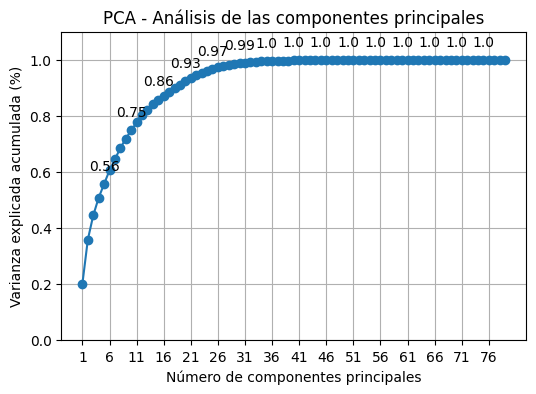

In [22]:
pca = PCA()
pca = pca.fit(X)

prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(prop_varianza_acum)) + 1,  # Corregido para coincidir con el número de componentes
    prop_varianza_acum,
    marker='o'
)

# Añadir anotaciones de 5 en 5 componentes
for x, y in zip(np.arange(len(prop_varianza_acum)) + 1, prop_varianza_acum):
    if x % 5 == 0:
        label = round(y, 2)
        ax.annotate(
            label,
            (x, y),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center'
        )

ax.set_ylim(0, 1.1)
ax.grid()
ax.set_xticks(np.arange(1, len(prop_varianza_acum) + 1, 5))
ax.set_title('PCA - Análisis de las componentes principales')
ax.set_xlabel('Número de componentes principales')
ax.set_ylabel('Varianza explicada acumulada (%)')
plt.savefig('pca.svg')
plt.show()

In [23]:
n_components_95 = np.where(prop_varianza_acum >= 0.95)[0][0] + 1

pca_95 = PCA(n_components=n_components_95)
X_pca_95 = pca_95.fit_transform(X)

df_new = pd.DataFrame(X_pca_95, columns=[f'PC{i+1}' for i in range(n_components_95)])

df_new

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,-1.069658,0.217471,-0.318395,-0.450545,2.047655,1.588652,-0.196077,0.178286,-2.979615,0.617462,...,0.215089,0.069860,0.066420,-0.085196,-0.249991,-1.986597,0.096730,1.616145,0.299874,0.106206
1,-2.568608,1.403109,1.007593,-0.795875,2.490980,1.572588,-0.118480,0.116585,-1.678954,0.762795,...,0.950982,0.909015,0.375750,1.143501,0.040453,-0.277799,-0.005328,0.640969,1.335441,-0.063490
2,3.245292,-2.858076,0.111767,-0.204784,-0.705411,1.396047,0.058475,-0.198667,0.676925,0.541025,...,2.877410,0.726649,0.527180,1.051250,-0.159482,-1.126918,-0.038753,0.870507,0.481642,0.066146
3,-3.607243,2.463475,1.563863,1.478907,-0.933658,2.149033,-0.139109,-0.052511,-0.163657,0.308370,...,2.215132,-0.347426,0.409111,0.923824,0.049017,0.045860,-0.078708,-0.158869,0.332608,-0.007995
4,2.772481,-2.736956,1.227673,-0.123206,-0.516633,2.301037,-0.520556,-0.106797,-0.966084,0.542984,...,1.196254,0.301897,0.444679,0.987286,0.101155,0.078182,-0.053337,0.337472,0.720996,-0.004120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80139,2.861362,-2.940433,0.346090,-0.372447,-1.312296,-1.593414,-0.166005,-0.262539,0.824165,0.250441,...,-0.175937,0.557660,0.009414,0.109371,0.083762,0.201489,0.032777,-0.115467,0.168925,0.025072
80140,3.139875,-2.615866,0.322375,-0.085244,-1.136617,-1.733125,-0.114938,-0.259111,0.890270,0.226993,...,-0.255594,0.217715,0.065750,0.142571,0.078418,0.085164,0.037129,-0.038928,0.321955,0.025748
80141,-1.359553,0.130791,-0.996245,-0.955247,1.654587,-0.891051,-0.024092,0.107417,-1.801767,0.248166,...,-1.475661,0.325606,-0.287552,-0.840235,-0.210060,-1.386630,0.124184,1.016352,-0.373722,0.095410
80142,2.865685,-2.936584,0.344825,-0.367906,-1.311710,-1.603994,-0.163866,-0.262588,0.828390,0.250465,...,-0.180313,0.535262,0.013023,0.113621,0.083214,0.193280,0.033190,-0.111437,0.175378,0.025064


## Predicción

Se utiliza el modelo de Redes Neuronales Convolucionales (CNN) para la clasificación de eventos dentro del conjunto de datos IoTID20, con un enfoque específico en identificar ataques potenciales. Este paso es donde el modelo aprende a distinguir entre comportamientos normales y anómalos basándose en las características seleccionadas.

### Elección de hiperparámetros

In [24]:
# Definir la ruta para los logs de TensorBoard
log_dir = f"{route}/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Inicializar el callback de TensorBoard
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

num_classes = len(np.unique(target))  # Asumiendo que 'target' está definido

# Define la función para crear el modelo compatible con keras-tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[8, 16, 32]),
        activation='relu',
        input_shape=(X_pca_95.shape[1], 1)
    ))
    model.add(MaxPooling1D(
        pool_size=hp.Choice('pool_size', values=[2, 4, 8]),
        ))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=50, max_value=100, step=50),
        activation='relu'
    ))

    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
        loss = 'binary_crossentropy'
        kfold = KFold(n_splits=5, shuffle=True)
    else:
        activation = 'softmax'
        units = num_classes
        loss = 'sparse_categorical_crossentropy'
        kfold = StratifiedKFold(n_splits=5, shuffle=True)

    model.add(Dense(units=units, activation=activation))
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model

# Inicializa el tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=40,
    directory='my_dir',
    project_name='intro_to_kt'
)

# Crea callbacks para detener el entrenamiento temprano
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Inicia la búsqueda de hiperparámetros
tuner.search(X_pca_95, target, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Obtiene el mejor modelo
best_model = tuner.get_best_models()[0]

# Imprime los mejores hiperparámetros
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Mejores hiperparámetros encontrados:")
print(best_hyperparameters.values)

Trial 90 Complete [00h 01m 41s]
val_accuracy: 0.957452118396759

Best val_accuracy So Far: 0.9636284112930298
Total elapsed time: 01h 35m 54s
Mejores hiperparámetros encontrados:
{'filters': 128, 'kernel_size': 8, 'pool_size': 8, 'dense_units': 100, 'tuner/epochs': 40, 'tuner/initial_epoch': 14, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0081'}


In [57]:
X_train, X_val, y_train, y_val = train_test_split(X_pca_95, target, test_size=0.2, random_state=42)

class CustomMetrics(Callback):
    def __init__(self, validation_data=()):
        super(CustomMetrics, self).__init__()
        self.X_val, self.y_val = validation_data
        # Inicializar listas para almacenar métricas por época
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = (np.asarray(self.model.predict(self.X_val))).round()
        val_targ = self.y_val
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        # Actualizar listas con las métricas calculadas
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        # Opcional: Guardar métricas en logs para visualización en TensorBoard
        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(f' — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}')
        return

custom_metrics = CustomMetrics(validation_data=(X_val, y_val))

history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                         epochs=40, callbacks=[custom_metrics, tensorboard_callback, stop_early])

Epoch 1/40
   1/2004 [..............................] - ETA: 1:36 - loss: 0.1047 - accuracy: 0.9688

501/501 [==============================] - 1s 2ms/step
 — val_f1: 0.9589429481529026 — val_precision: 0.9590671447169459 — val_recall: 0.9589091196126928
2004/2004 [==============================] - 15s 7ms/step - loss: 0.1268 - accuracy: 0.9542 - val_loss: 0.1120 - val_accuracy: 0.9589 - val_f1: 0.9589 - val_recall: 0.9589 - val_precision: 0.9591
Epoch 2/40
501/501 [==============================] - 1s 2ms/step
 — val_f1: 0.9525804141980951 — val_precision: 0.9526553401355682 — val_recall: 0.9525553657519663
2004/2004 [==============================] - 11s 6ms/step - loss: 0.1176 - accuracy: 0.9564 - val_loss: 0.1240 - val_accuracy: 0.9526 - val_f1: 0.9526 - val_recall: 0.9526 - val_precision: 0.9527
Epoch 3/40
501/501 [==============================] - 1s 2ms/step
 — val_f1: 0.9520230096168396 — val_precision: 0.9520221140131704 — val_recall: 0.9520239719234614
2004/2004 [==============================] - 10s 5ms/step - loss: 0.1134 - accuracy: 0.9580 - val_loss: 0.1139 - val_accurac

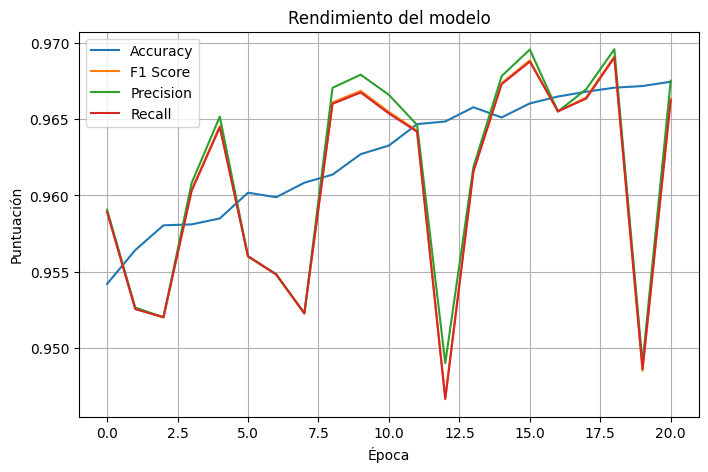

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(custom_metrics.val_f1s, label='F1 Score')
plt.plot(custom_metrics.val_precisions, label='Precision')
plt.plot(custom_metrics.val_recalls, label='Recall')
plt.title('Rendimiento del modelo')
plt.ylabel('Puntuación')
plt.xlabel('Época')
plt.legend(loc='upper left')
plt.savefig(f'{route}/metrics.svg')
plt.grid()
plt.show()

In [59]:
metrics_data = pd.DataFrame({
    'Accuracy': history.history['accuracy'],
    'F1 Score': custom_metrics.val_f1s,
    'Precision': custom_metrics.val_precisions,
    'Recall': custom_metrics.val_recalls
})

# Guardar el DataFrame como CSV
metrics_data.to_csv(f'{route}/model_metrics.csv', index=False)

In [52]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [53]:
%tensorboard --logdir content/drive/myDrive/RNAE/logs/fit

/bin/bash: line 1: kill: (35194) - No such process


<IPython.core.display.Javascript object>